<a href="https://colab.research.google.com/github/Aadityasindhuu/Aadityasindhuu/blob/main/Liver_Cirrhosis_Stage_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                            recall_score, confusion_matrix, classification_report,
                            roc_curve, auc, RocCurveDisplay)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# For file upload in Colab
from google.colab import files

# Set random seed for reproducibility
np.random.seed(42)

# %% [markdown]
"""
## 1. Data Loading & Preprocessing
"""

# %%
# Upload the CSV file
print("Please upload the CSV file containing the dataset:")
uploaded = files.upload()

# Get the uploaded filename
csv_filename = next(iter(uploaded))
print(f"\nUploaded file: {csv_filename}")

Please upload the CSV file containing the dataset:


Saving liver_cirrhosis.csv to liver_cirrhosis.csv

Uploaded file: liver_cirrhosis.csv


In [ ]:
# %%
# Load the dataset
df = pd.read_csv(csv_filename)
print("Dataset loaded successfully!")
display(df.head())

# %%
# Basic dataset info
print("\nDataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isna().sum())

Dataset loaded successfully!


,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  object 
 2   Drug           25000 non-null  object 
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  object 
 5   Ascites        25000 non-null  object 
 6   Hepatomegaly   25000 non-null  object 
 7   Spiders        25000 non-null  object 
 8   Edema          25000 non-null  object 
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    25000 non-null  floa

In [ ]:
# %%
# Handle missing values
def handle_missing_data(df):
    """Handle missing values in the dataset with appropriate strategies."""

    # Create a copy to avoid SettingWithCopyWarning
    df_clean = df.copy()

    # For numerical columns, impute with median (less sensitive to outliers)
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    num_imputer = SimpleImputer(strategy='median')
    df_clean[num_cols] = num_imputer.fit_transform(df_clean[num_cols])

    # For categorical columns, impute with mode (most frequent value)
    cat_cols = df.select_dtypes(include=['object']).columns
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df_clean[cat_cols] = cat_imputer.fit_transform(df_clean[cat_cols])

    # Verify no missing values remain
    assert df_clean.isna().sum().sum() == 0, "There are still missing values!"

    return df_clean

df_clean = handle_missing_data(df)
print("\nMissing values after imputation:", df_clean.isna().sum().sum())


Missing values after imputation: 0


In [ ]:
# %%
# Encode categorical variables
def encode_categorical(df):
    """Encode categorical variables appropriately."""

    df_encoded = df.copy()

    # Binary categorical variables - use Label Encoding
    binary_cols = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
    binary_cols = [col for col in binary_cols if col in df_encoded.columns]  # Only keep cols that exist

    for col in binary_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        # Save the encoders for inference later
        joblib.dump(le, f'{col}_encoder.joblib')

    # For Drug (assuming it's nominal categorical with >2 categories) - use One-Hot Encoding
    if 'Drug' in df_encoded.columns:
        df_encoded = pd.get_dummies(df_encoded, columns=['Drug'], prefix='Drug', drop_first=True)

    # Status might be our target in some cases, but here we'll drop it as we're focusing on Stage
    if 'Status' in df_encoded.columns:
        df_encoded.drop('Status', axis=1, inplace=True)

    return df_encoded

df_encoded = encode_categorical(df_clean)
display(df_encoded.head())

# %%
# Check target variable distribution
print("\nTarget Variable Distribution:")
print(df_encoded['Stage'].value_counts())

,N_Days,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug_Placebo
0,2221.0,18499.0,0,0,1,0,0,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1.0,True
1,1230.0,19724.0,1,1,0,1,0,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2.0,True
2,4184.0,11839.0,0,0,0,0,0,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2.0,True
3,2090.0,16467.0,0,0,0,0,0,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2.0,True
4,2105.0,21699.0,0,0,1,0,0,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1.0,True



Target Variable Distribution:
Stage
2.0    8441
3.0    8294
1.0    8265
Name: count, dtype: int64


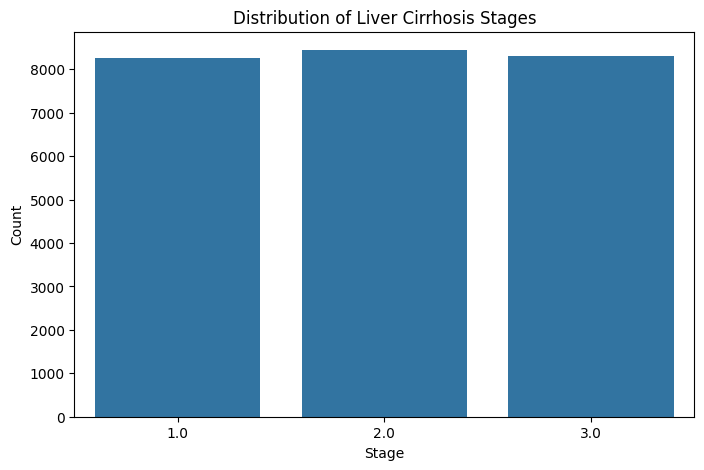

In [ ]:
# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Stage', data=df_encoded)
plt.title('Distribution of Liver Cirrhosis Stages')
plt.xlabel('Stage')
plt.ylabel('Count')
plt.show()

In [ ]:
# %%
# Prepare features and target
X = df_encoded.drop('Stage', axis=1)
y = df_encoded['Stage']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize numerical features (excluding binary/categorical)
def standardize_features(X_train, X_test):
    """Standardize numerical features while preserving binary/categorical."""

    # Identify numerical columns (excluding binary encoded ones)
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
    binary_cols = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
    binary_cols = [col for col in binary_cols if col in X_train.columns]  # Only keep cols that exist
    num_cols = [col for col in num_cols if col not in binary_cols]

    # Standardize numerical features
    scaler = StandardScaler()
    X_train_std = X_train.copy()
    X_test_std = X_test.copy()

    X_train_std[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test_std[num_cols] = scaler.transform(X_test[num_cols])

    # Save the scaler for inference later
    joblib.dump(scaler, 'feature_scaler.joblib')

    return X_train_std, X_test_std

X_train_std, X_test_std = standardize_features(X_train, X_test)


=== Exploratory Data Analysis ===


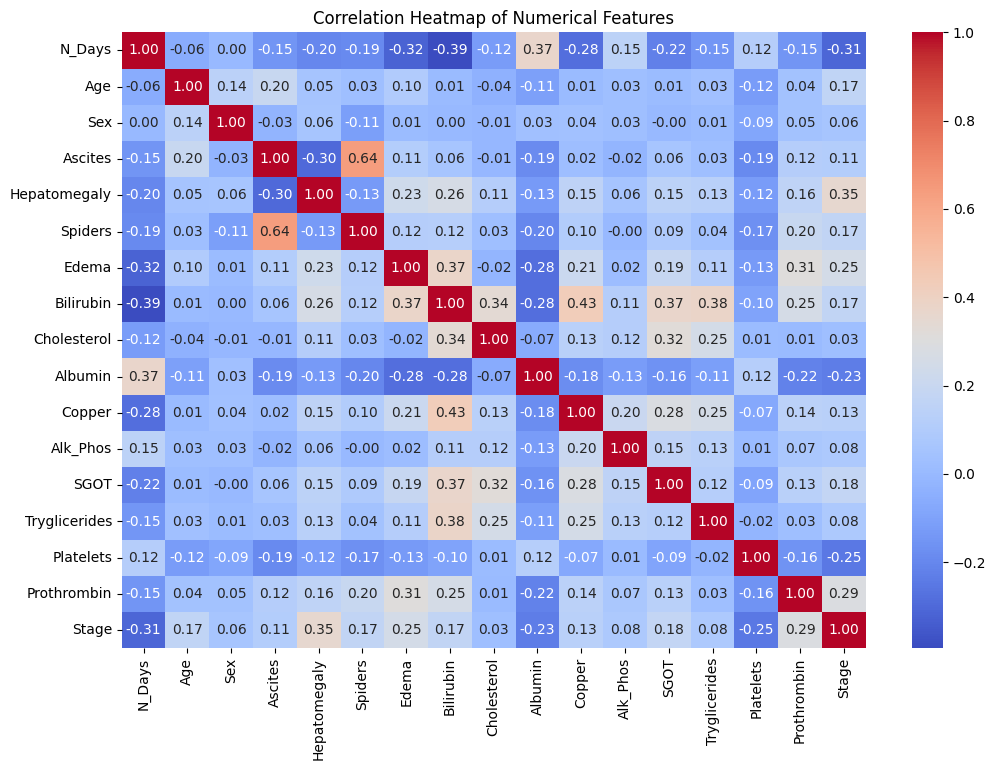

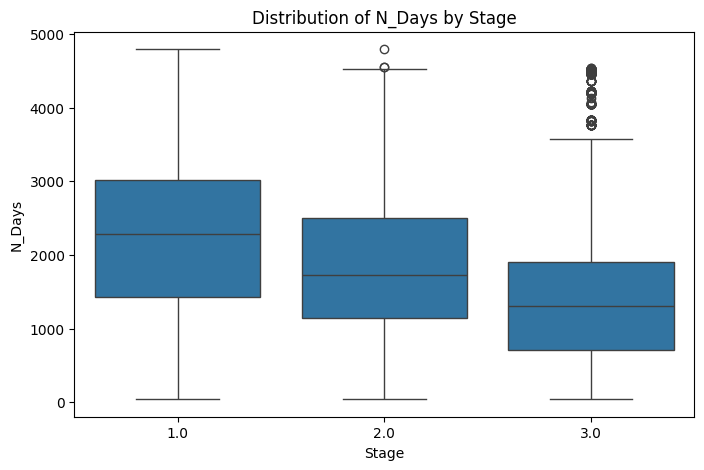

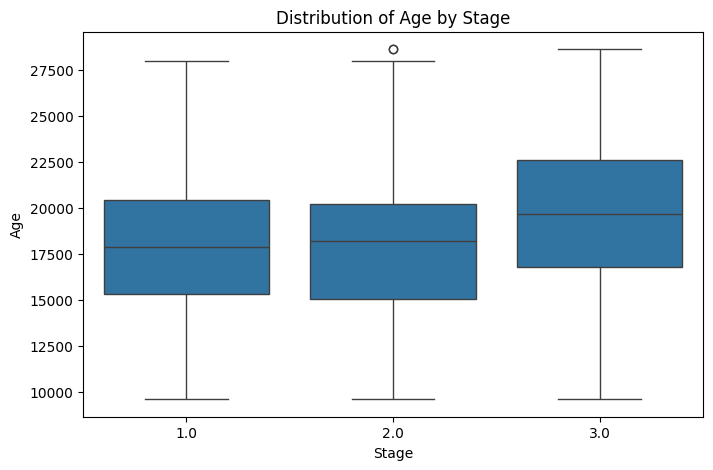

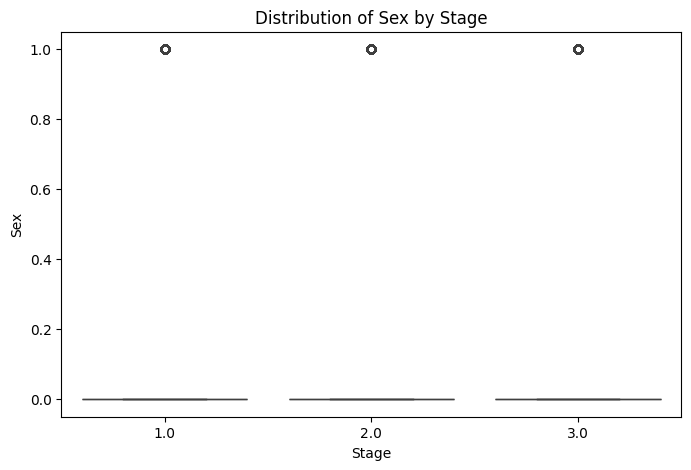

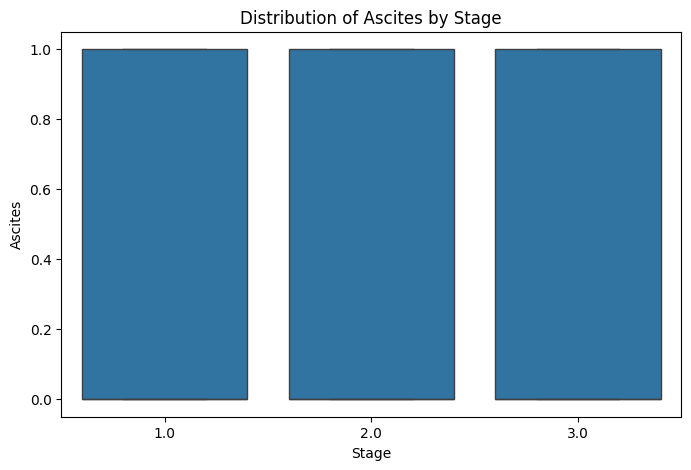

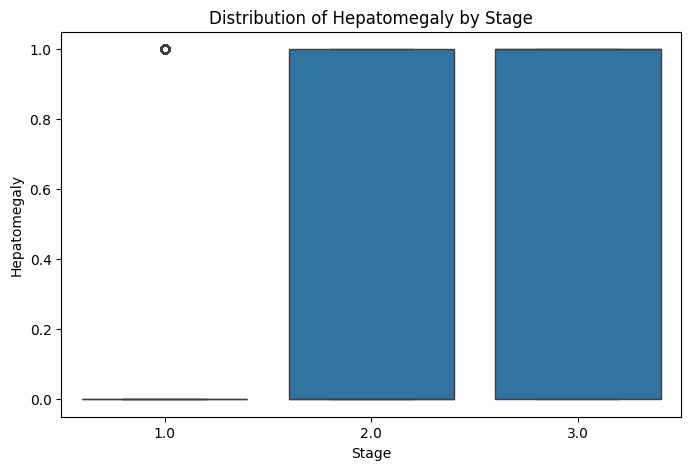

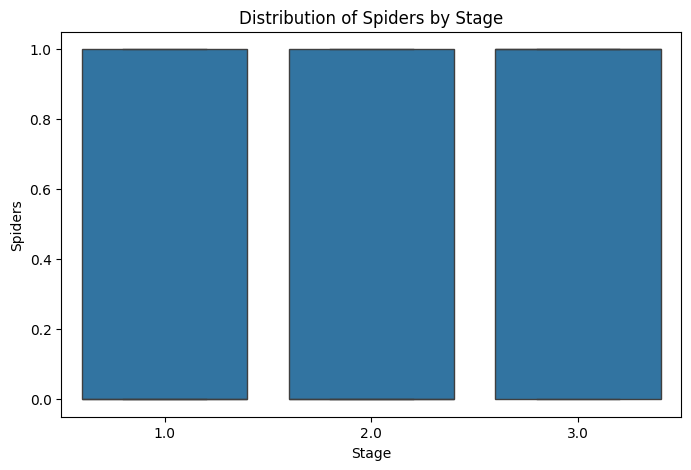

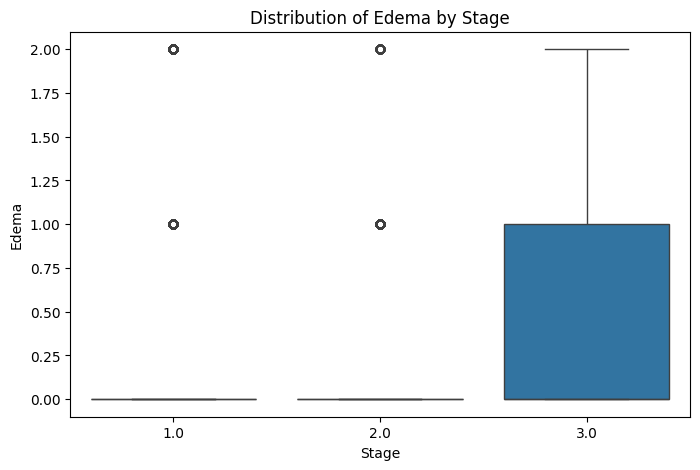

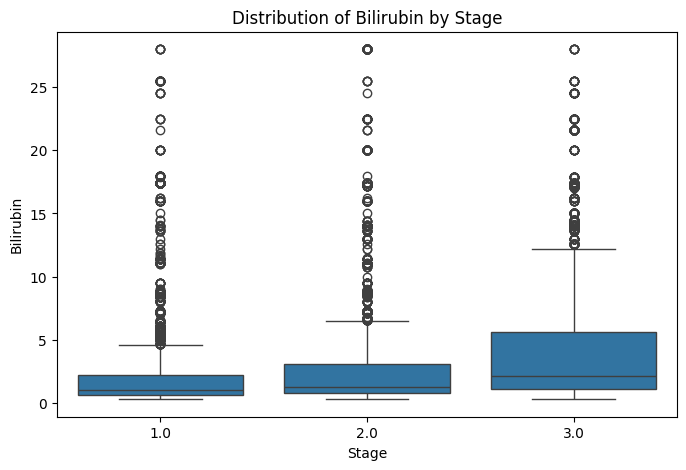

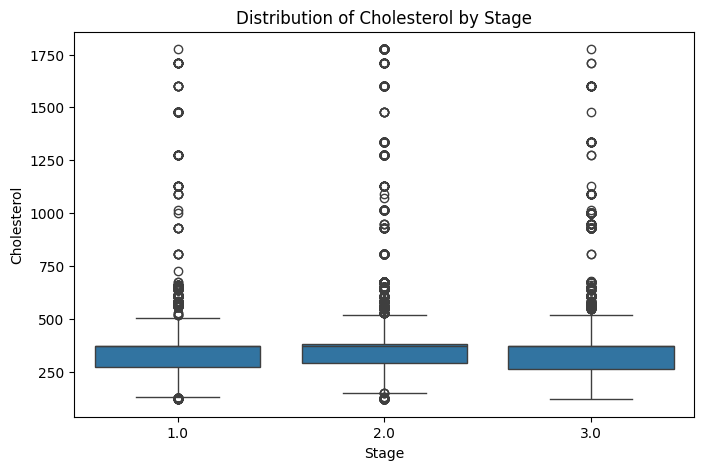

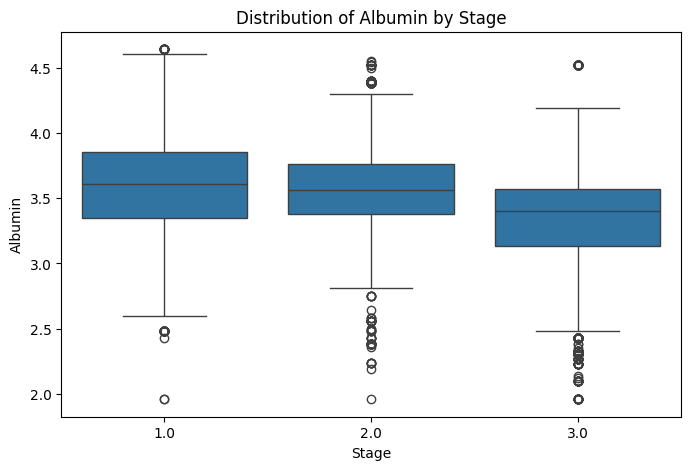

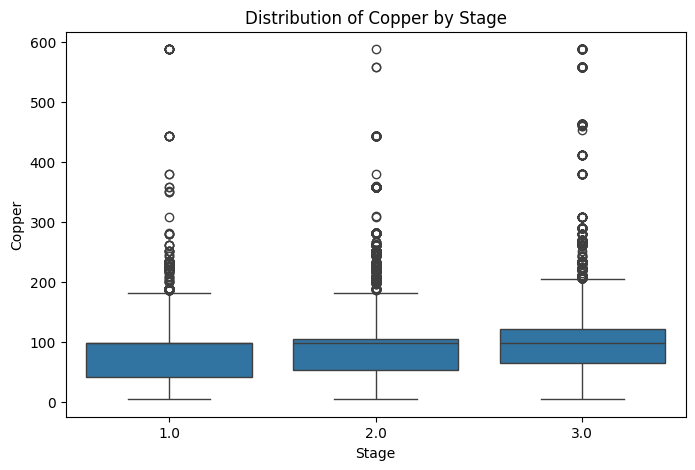

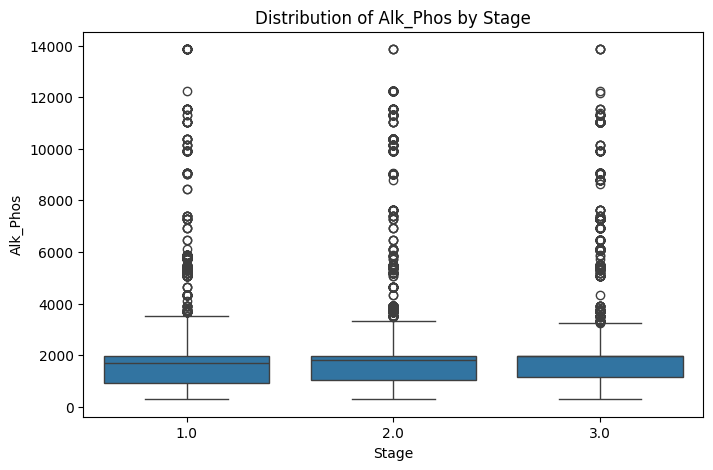

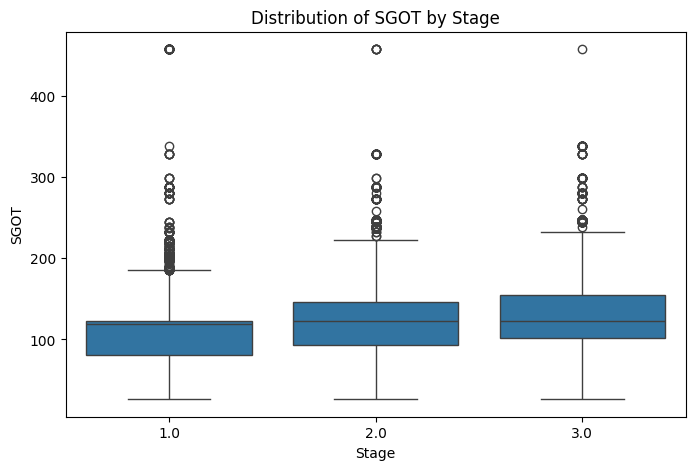

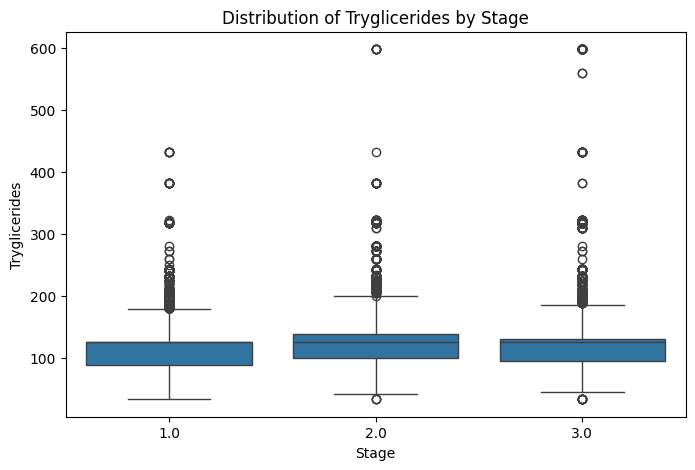

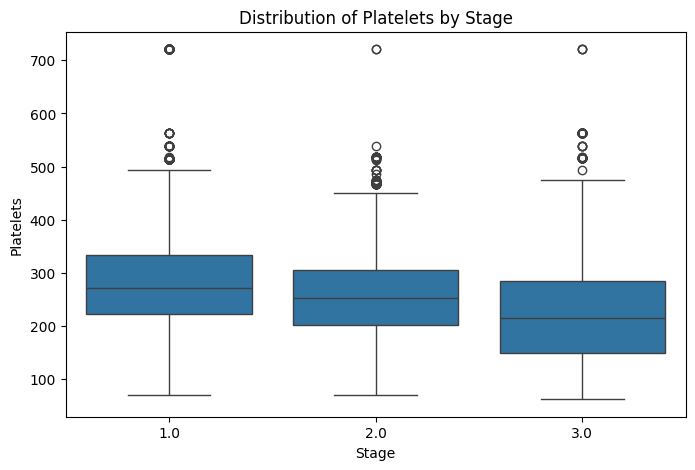

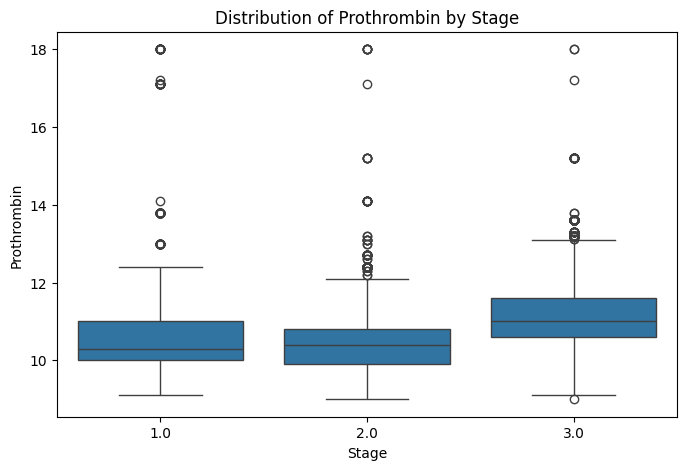

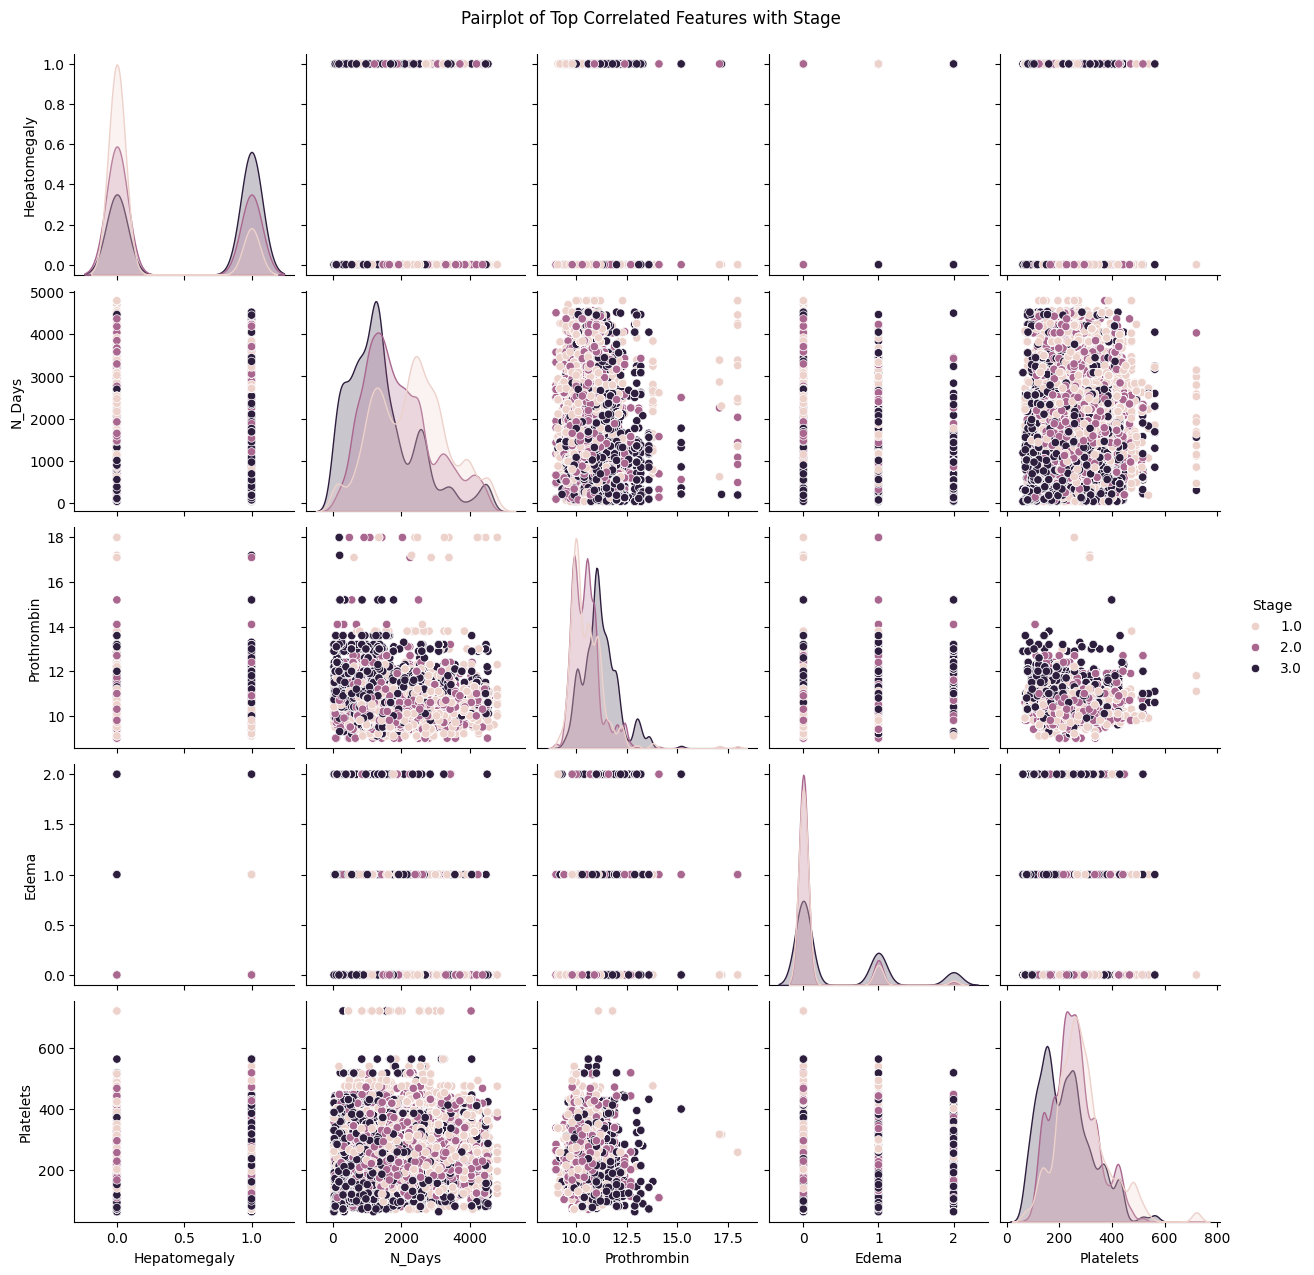

In [ ]:
# %%
# Exploratory Data Analysis (EDA)
def perform_eda(df, target_col='Stage'):
    """Perform exploratory data analysis."""

    print("\n=== Exploratory Data Analysis ===")

    # 1. Correlation heatmap (for numerical features)
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numerical Features')
    plt.show()

    # 2. Feature distributions by stage
    for col in num_cols:
        if col != target_col:
            plt.figure(figsize=(8, 5))
            sns.boxplot(x=target_col, y=col, data=df)
            plt.title(f'Distribution of {col} by Stage')
            plt.show()

    # 3. Pairplot of top correlated features with target
    if target_col in num_cols:
        corr_with_target = df[num_cols].corr()[target_col].abs().sort_values(ascending=False)
        top_features = corr_with_target.index[1:6]  # top 5 features
        sns.pairplot(df[list(top_features) + [target_col]], hue=target_col)
        plt.suptitle('Pairplot of Top Correlated Features with Stage', y=1.02)
        plt.show()

perform_eda(df_encoded)



=== Evaluating Random Forest ===
Cross-validation Accuracy: 0.952 ± 0.002

Classification Report:
              precision    recall  f1-score   support

         1.0       0.96      0.93      0.95      1653
         2.0       0.93      0.95      0.94      1688
         3.0       0.96      0.97      0.97      1659

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



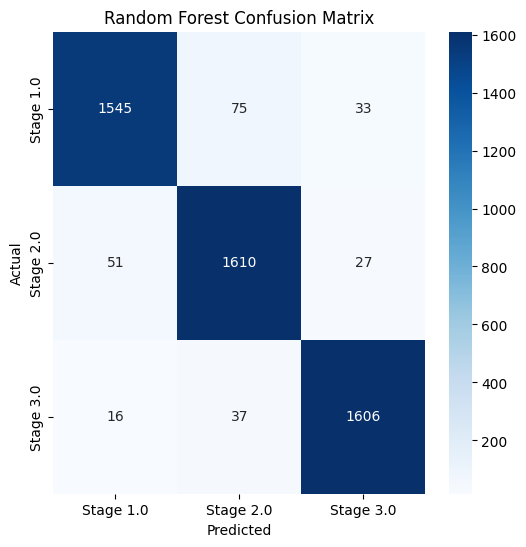


=== Evaluating XGBoost ===
Cross-validation Accuracy: 0.962 ± 0.002

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1653
           1       0.94      0.96      0.95      1688
           2       0.97      0.97      0.97      1659

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



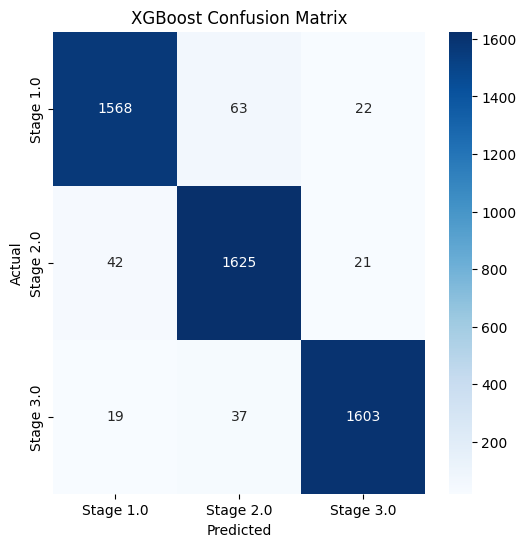


=== Evaluating SVM ===
Cross-validation Accuracy: 0.813 ± 0.004

Classification Report:
              precision    recall  f1-score   support

         1.0       0.80      0.80      0.80      1653
         2.0       0.76      0.80      0.78      1688
         3.0       0.88      0.85      0.86      1659

    accuracy                           0.81      5000
   macro avg       0.82      0.81      0.82      5000
weighted avg       0.82      0.81      0.81      5000



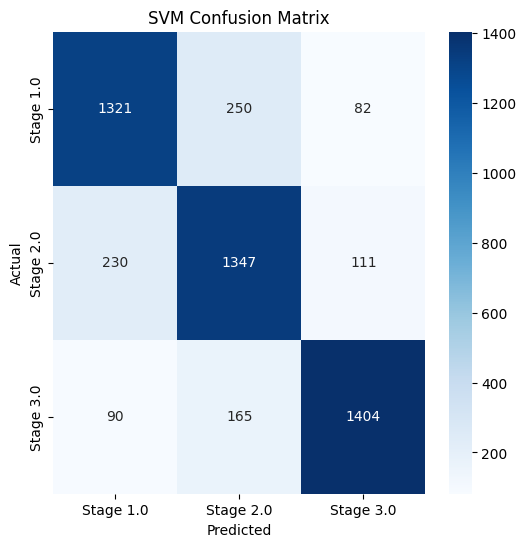


=== Evaluating Logistic Regression ===
Cross-validation Accuracy: 0.593 ± 0.012

Classification Report:
              precision    recall  f1-score   support

         1.0       0.56      0.60      0.58      1653
         2.0       0.51      0.46      0.49      1688
         3.0       0.65      0.68      0.66      1659

    accuracy                           0.58      5000
   macro avg       0.57      0.58      0.58      5000
weighted avg       0.57      0.58      0.58      5000



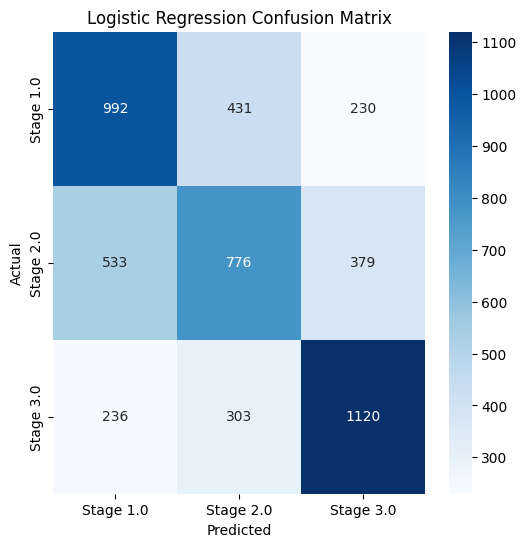

In [ ]:
# %% [markdown]
"""
## 2. Model Building
"""

# %%
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'SVM': SVC(random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Evaluate each model
results = {}
for name, model in models.items():
    print(f"\n=== Evaluating {name} ===")

    # Convert target variable to zero-indexed integers for XGBoost
    if name == 'XGBoost':
        y_train_processed = y_train.astype(int) - 1
        y_test_processed = y_test.astype(int) - 1
    else:
        y_train_processed = y_train
        y_test_processed = y_test

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_std, y_train_processed, cv=cv, scoring='accuracy')
    print(f"Cross-validation Accuracy: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

    # Train and evaluate on test set
    model.fit(X_train_std, y_train_processed)
    y_pred = model.predict(X_test_std)

    # Calculate metrics
    accuracy = accuracy_score(y_test_processed, y_pred)
    precision = precision_score(y_test_processed, y_pred, average='weighted')
    recall = recall_score(y_test_processed, y_pred, average='weighted')
    f1 = f1_score(y_test_processed, y_pred, average='weighted')

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_scores': cv_scores
    }

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test_processed, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test_processed, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'Stage {i}' for i in sorted(y.unique())],
                yticklabels=[f'Stage {i}' for i in sorted(y.unique())])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

<Figure size 1000x600 with 0 Axes>

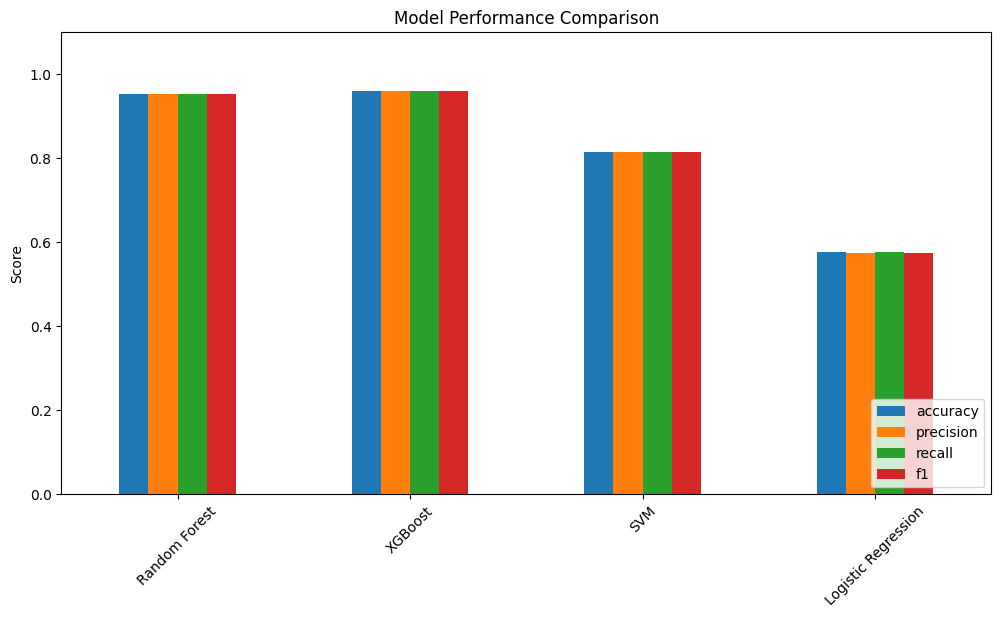

In [ ]:
# %% [markdown]
"""
## 3. Visualizations
"""

# %%
# Compare model performance
metrics_df = pd.DataFrame.from_dict({k: v for k, v in results.items() if k != 'model'}, orient='index')
metrics_df = metrics_df[['accuracy', 'precision', 'recall', 'f1']]

# Plot metrics comparison
plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.show()

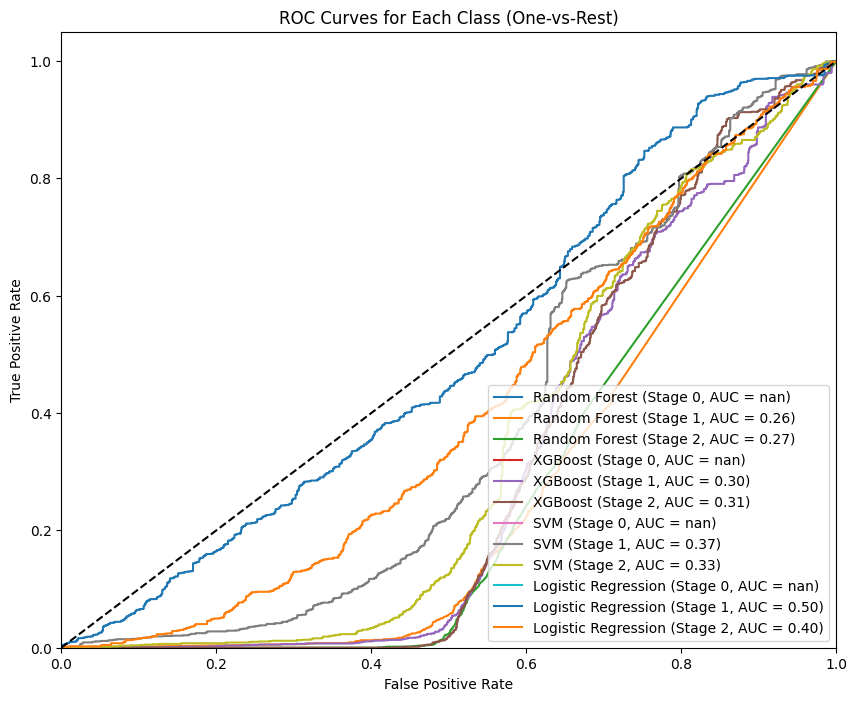

In [ ]:
# %%
# ROC curves for multiclass (one-vs-rest approach)
plt.figure(figsize=(10, 8))
for name, result in results.items():
    model = result['model']

    # Check if model supports predict_proba
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test_std)

        # Compute ROC curve and ROC area for each class
        n_classes = len(np.unique(y))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot all ROC curves
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i],
                     label=f'{name} (Stage {i}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()


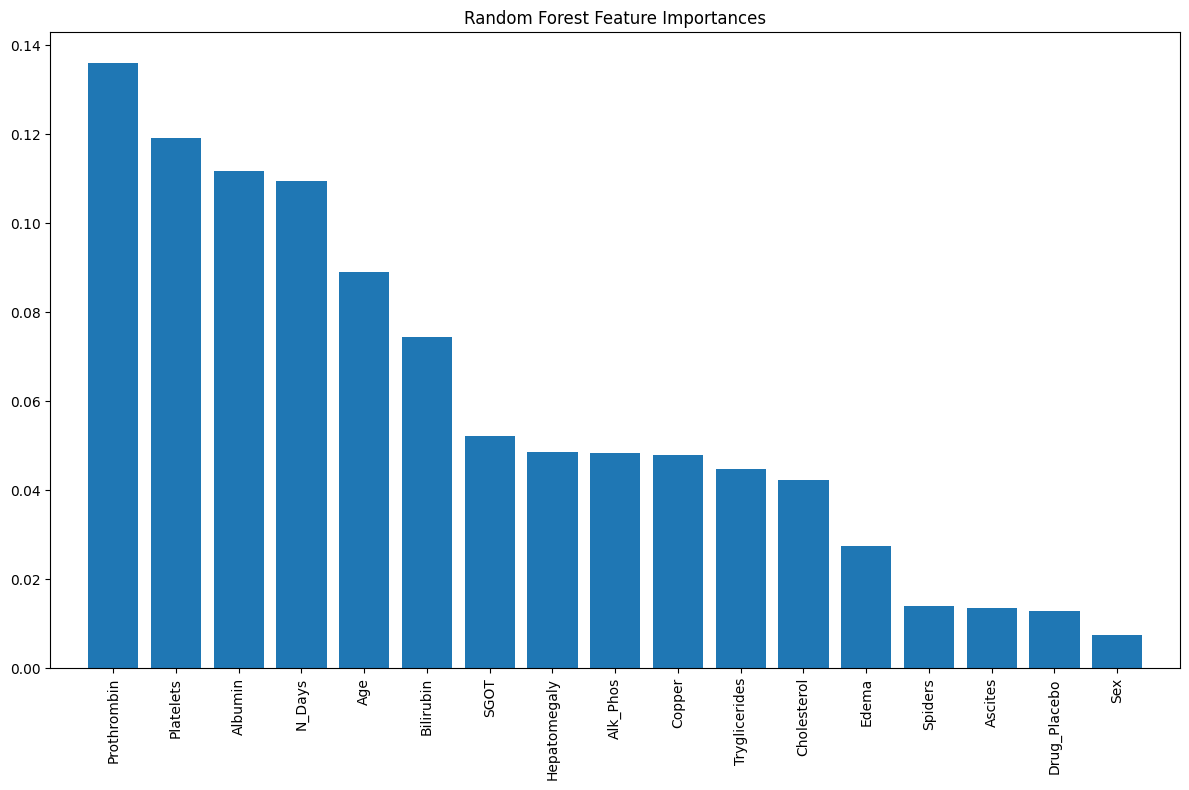

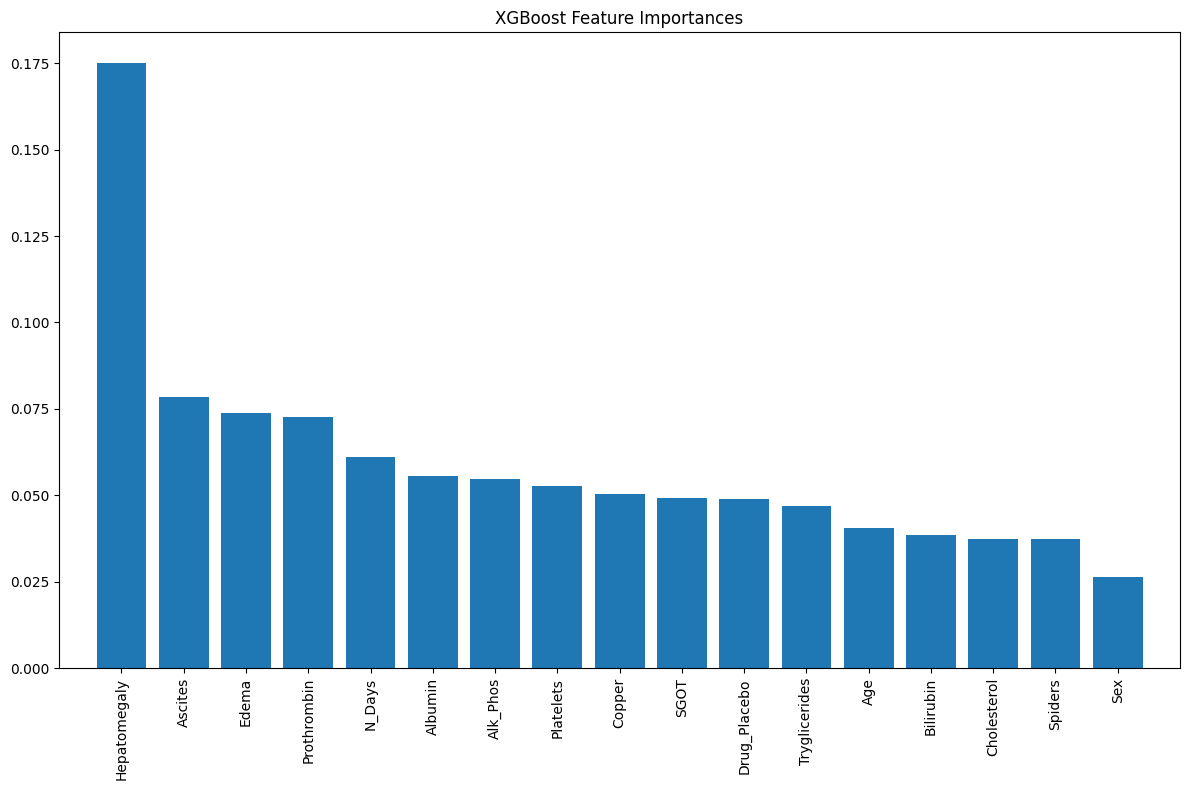

In [ ]:
# %%
# Feature importance for tree-based models
for name in ['Random Forest', 'XGBoost']:
    if name in results:
        model = results[name]['model']

        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]

            plt.figure(figsize=(12, 8))
            plt.title(f"{name} Feature Importances")
            plt.bar(range(X_train_std.shape[1]), importances[indices], align="center")
            plt.xticks(range(X_train_std.shape[1]), X_train_std.columns[indices], rotation=90)
            plt.xlim([-1, X_train_std.shape[1]])
            plt.tight_layout()
            plt.show()

In [ ]:
"""
## 4. Model Selection
"""

# %%
# Select best model based on F1 score (can change to accuracy if preferred)
best_model_name = max(results.items(), key=lambda x: x[1]['f1'])[0]
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")
print(f"F1 Score: {results[best_model_name]['f1']:.3f}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.3f}")

# Save the best model
joblib.dump(best_model, 'best_cirrhosis_model.joblib')
print("\nBest model saved as 'best_cirrhosis_model.joblib'")


Best Model: XGBoost
F1 Score: 0.959
Accuracy: 0.959

Best model saved as 'best_cirrhosis_model.joblib'


In [ ]:
# %% [markdown]
"""
## 5. Inference
"""

# %%
# Function to preprocess new data for inference
def preprocess_new_data(input_data, feature_names, X_train_std):
    """Preprocess new data in the same way as training data."""

    # Create a DataFrame with all expected feature names and initialize with NaNs
    # Set the data types based on the training data to avoid imputation errors
    new_df = pd.DataFrame(index=[0], columns=feature_names)

    # Populate the new DataFrame with input data
    for col, value in input_data.items():
        if col in feature_names:
             new_df.loc[0, col] = value
        else:
            print(f"Warning: Input column '{col}' not found in expected features.")


    # Identify numerical and categorical columns based on the training data
    # Use the dtypes of X_train_std to correctly identify numerical and categorical columns
    num_cols_train = X_train_std.select_dtypes(include=np.number).columns
    cat_cols_train = X_train_std.select_dtypes(include=['object', 'bool']).columns

    # Separate columns in new_df based on their intended type (before encoding)
    original_cat_cols = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Drug']
    original_num_cols = [col for col in feature_names if col not in original_cat_cols and col in new_df.columns]


    # Handle missing values (using the same strategy as training)

    # Impute numerical columns (based on original numerical columns)
    num_imputer = SimpleImputer(strategy='median')
    # Fit on training data's numerical columns and transform new data's corresponding columns
    if original_num_cols:
        num_imputer.fit(X_train_std[original_num_cols])
        new_df[original_num_cols] = num_imputer.transform(new_df[original_num_cols])


    # Impute categorical columns (based on original categorical columns)
    cat_imputer = SimpleImputer(strategy='most_frequent')
    # Fit on training data's original categorical columns and transform new data's corresponding columns
    original_cat_cols_in_train = [col for col in original_cat_cols if col in df_clean.columns] # Use df_clean to get original cat columns
    cat_cols_to_impute = [col for col in original_cat_cols_in_train if col in new_df.columns]

    if cat_cols_to_impute:
        # Ensure columns are of object type before imputation if they were originally
        for col in cat_cols_to_impute:
            new_df[col] = new_df[col].astype(object)
        cat_imputer.fit(df_clean[cat_cols_to_impute]) # Fit on original categorical columns from df_clean
        new_df[cat_cols_to_impute] = cat_imputer.transform(new_df[cat_cols_to_impute])


    # Encode categorical variables
    binary_cols = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
    for col in binary_cols:
        if col in new_df.columns:
            le = joblib.load(f'{col}_encoder.joblib')
            # Ensure the column has the correct dtype before transformation
            new_df[col] = new_df[col].astype(str)
            # Use .loc to avoid SettingWithCopyWarning and reshape for the encoder
            new_df.loc[:, col] = le.transform(new_df[col].values.reshape(-1, 1)).astype(int) # Convert to int after encoding


    if 'Drug' in new_df.columns:
        # Ensure 'Drug' column is of object type before get_dummies
        new_df['Drug'] = new_df['Drug'].astype(object)
        new_df = pd.get_dummies(new_df, columns=['Drug'], prefix='Drug', drop_first=True)

    # Ensure all expected columns from X_train_std are present (add missing with 0)
    expected_cols = X_train_std.columns
    for col in expected_cols:
        if col not in new_df.columns:
            new_df[col] = 0

    # Reorder columns again after one-hot encoding to ensure they match
    new_df = new_df[expected_cols]

    # Ensure dtypes match X_train_std, especially for encoded binary columns
    for col in new_df.columns:
        if col in X_train_std.columns:
            new_df[col] = new_df[col].astype(X_train_std[col].dtype)


    # Standardize numerical features
    scaler = joblib.load('feature_scaler.joblib')
    # Exclude binary columns (now encoded as numbers) from standardization but include original numerical ones
    # Use the numerical columns identified from X_train_std for standardization
    num_cols_to_standardize = [col for col in num_cols_train if col not in binary_cols and col in new_df.columns]

    if num_cols_to_standardize:
      new_df[num_cols_to_standardize] = scaler.transform(new_df[num_cols_to_standardize])

    return new_df

# %%
# Example inference with dummy patient data
print("\n=== Example Inference ===")


=== Example Inference ===


In [ ]:
# Example inference with dummy patient data
print("\n=== Example Inference ===")

# Load the saved model
loaded_model = joblib.load('best_cirrhosis_model.joblib')

# Create dummy patient data (replace with actual values)
# Note: This should match the features in your original dataset
dummy_patient = {
    'Age': 50,
    'Sex': 'F',  # 'F' or 'M'
    'Albumin': 3.5,
    'Alk_Phos': 120,
    # 'AST': 45, # Removed as it's not in the original dataset
    'Bilirubin': 1.2,
    'Cholesterol': 200,
    'Copper': 90,
    'Hepatomegaly': 'Y',  # 'Y' or 'N'
    'Prothrombin': 11,
    'Spiders': 'Y',       # 'Y' or 'N'
    'Edema': 'N',         # 'Y' or 'N'
    'Ascites': 'N',       # 'Y' or 'N'
    'Drug': 'D-penicillamine',  # or 'placebo'
    'N_Days': 1000, # Added N_Days as it is in the training data
    'Platelets': 200, # Added Platelets as it is in the training data
    'SGOT': 50, # Added SGOT as it is in the training data
    'Tryglicerides': 100 # Added Tryglicerides as it is in the training data
}

# Preprocess the dummy data
processed_data = preprocess_new_data(dummy_patient, X.columns, X_train_std)

# Make prediction
predicted_stage = loaded_model.predict(processed_data)[0]
predicted_proba = loaded_model.predict_proba(processed_data)[0]

print(f"\nPredicted Stage: {predicted_stage}")
print("Prediction Probabilities:")
for i, prob in enumerate(predicted_proba):
    print(f"Stage {i}: {prob:.2%}")


=== Example Inference ===

Predicted Stage: 2
Prediction Probabilities:
Stage 0: 1.79%
Stage 1: 7.48%
Stage 2: 90.73%


In [ ]:
# %%
# Function for interactive inference (in Colab)
def interactive_inference():
    """Interactive function to input patient data and get predictions."""
    from IPython.display import display
    import ipywidgets as widgets

    print("Enter patient details for cirrhosis stage prediction:")

    # Create input widgets for key features
    age = widgets.FloatText(value=50, description='Age:')
    sex = widgets.Dropdown(options=['F', 'M'], description='Sex:')
    albumin = widgets.FloatText(value=3.5, description='Albumin:')
    bilirubin = widgets.FloatText(value=1.2, description='Bilirubin:')
    # Removed AST as it's not in the original dataset
    # ast = widgets.FloatText(value=45, description='AST:')
    hepatomegaly = widgets.Dropdown(options=['Y', 'N'], description='Hepatomegaly:')
    spiders = widgets.Dropdown(options=['Y', 'N'], description='Spiders:')
    edema = widgets.Dropdown(options=['Y', 'N'], description='Edema:')
    ascites = widgets.Dropdown(options=['Y', 'N'], description='Ascites:')

    predict_btn = widgets.Button(description="Predict Stage")
    output = widgets.Output()

    def on_predict_click(b):
        with output:
            output.clear_output()
            # Create patient dictionary
            patient_data = {
                'Age': age.value,
                'Sex': sex.value,
                'Albumin': albumin.value,
                'Bilirubin': bilirubin.value,
                # 'AST': ast.value, # Removed
                'Hepatomegaly': hepatomegaly.value,
                'Spiders': spiders.value,
                'Edema': edema.value,
                'Ascites': ascites.value,
                # Add default values for other required features present in X.columns
                'Alk_Phos': 120.0,
                'Cholesterol': 200.0,
                'Copper': 90.0,
                'Prothrombin': 11.0,
                'Drug': 'D-penicillamine', # or 'placebo'
                'N_Days': 1000.0,
                'Platelets': 200.0,
                'SGOT': 50.0,
                'Tryglicerides': 100.0
            }

            # Preprocess and predict - Pass X_train_std
            processed_data = preprocess_new_data(patient_data, X.columns, X_train_std)
            predicted_stage = loaded_model.predict(processed_data)[0]
            predicted_proba = loaded_model.predict_proba(processed_data)[0]

            print("\nPrediction Results:")
            # Adjust predicted stage back to original labels if necessary (XGBoost was zero-indexed)
            # Check the type of the loaded_model to adjust the predicted stage correctly
            if isinstance(loaded_model, XGBClassifier):
                 predicted_stage = predicted_stage + 1 # Add 1 to convert back to 1, 2, 3

            print(f"Predicted Stage: {predicted_stage}")
            print("Prediction Probabilities:")
            # Adjust stage labels for probability output based on the model type
            stage_labels = sorted(y.unique()) # Use original y labels for clarity
            for i, prob in enumerate(predicted_proba):
                 # Map probability index to original stage label
                 print(f"Stage {stage_labels[i]}: {prob:.2%}")


    predict_btn.on_click(on_predict_click)

    # Display widgets
    # Include AST widget if it was part of the original features and you want to add it back
    display(widgets.VBox([age, sex, albumin, bilirubin,
                         hepatomegaly, spiders, edema, ascites,
                         predict_btn, output]))

# Run interactive inference
interactive_inference()

Enter patient details for cirrhosis stage prediction:


In [ ]:
# %%
# Create the app.py file content as a list of strings and join them
app_py_lines = [
    "import streamlit as st",
    "import pandas as pd",
    "import numpy as np",
    "import joblib",
    "from sklearn.preprocessing import LabelEncoder",
    "import os",
    "",
    "# Set page config",
    "st.set_page_config(",
    "    page_title='Liver Cirrhosis Stage Prediction',",
    "    page_icon='🩺',",
    "    layout='wide'",
    ")",
    "",
    "# Load model and preprocessing objects",
    "@st.cache_resource",
    "def load_artifacts():",
    "    model = joblib.load('artifacts/best_cirrhosis_model.joblib')",
    "    scaler = joblib.load('artifacts/feature_scaler.joblib')",
    "",
    "    # Load encoders",
    "    encoders = {}",
    "    encoder_files = {",
    "        'Sex': 'Sex_encoder.joblib',",
    "        'Ascites': 'Ascites_encoder.joblib',",
    "        'Hepatomegaly': 'Hepatomegaly_encoder.joblib',",
    "        'Spiders': 'Spiders_encoder.joblib',",
    "        'Edema': 'Edema_encoder.joblib'",
    "    }",
    "",
    "    for col, filename in encoder_files.items():",
    "        try:",
    "            encoders[col] = joblib.load(f'artifacts/{filename}')",
    "        except:",
    "            # Create dummy encoder if file not found",
    "            encoders[col] = LabelEncoder()",
    "            # Fit with expected values",
    "            if col == 'Sex':",
    "                encoders[col].fit(['F', 'M'])",
    "            else:",
    "                encoders[col].fit(['Y', 'N'])",
    "",
    "",
    "    return model, scaler, encoders",
    "",
    "# Load artifacts outside the function for direct access",
    "model, scaler, encoders = load_artifacts()",
    "",
    "",
    "# Expected feature names (adjust based on your model)",
    "# Get feature names from training (adjust based on your actual features)",
    "# Ensure all features from X.columns are included",
    "feature_names = ['N_Days', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema',",
    "                 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',",
    "                 'Tryglicerides', 'Platelets', 'Prothrombin', 'Drug_Placebo']",
    "",
    "",
    "# App UI",
    "st.title('🩺 Liver Cirrhosis Stage Prediction')",
    "st.write('''",
    "Predict the histologic stage of liver disease (1, 2, or 3) based on clinical and laboratory data.",
    "This tool is for research purposes only and should not replace professional medical advice.",
    "''')",
    "",
    "with st.expander('ℹ️ About this tool'):",
    "    st.write('''",
    "    - **Stage 1**: Early fibrosis with no significant scarring",
    "    - **Stage 2**: Moderate fibrosis with some scarring",
    "    - **Stage 3**: Severe fibrosis/cirrhosis with extensive scarring",
    "    ''')",
    "    st.write('Model: XGBoost Classifier (trained on Mayo Clinic PBC data)') # Updated model name",
    "",
    "",
    "# Input form",
    "with st.form('patient_form'):",
    "    st.subheader('Patient Clinical Data')",
    "",
    "    col1, col2 = st.columns(2)",
    "",
    "    with col1:",
    "        n_days = st.number_input('Number of Days since Diagnosis', min_value=0, value=1000)",
    "        age = st.number_input('Age (years)', min_value=18, max_value=100, value=50)",
    "        sex = st.radio('Sex', ['F', 'M'], horizontal=True)",
    "        albumin = st.number_input('Albumin (g/dL)', min_value=1.0, max_value=6.0, value=3.5, step=0.1)",
    "        alk_phos = st.number_input('Alkaline Phosphatase (U/L)', min_value=0, value=120)",
    "",
    "",
    "    with col2:",
    "        bilirubin = st.number_input('Bilirubin (mg/dL)', min_value=0.0, value=1.2, step=0.1)",
    "        cholesterol = st.number_input('Cholesterol (mg/dL)', min_value=0, value=200)",
    "        prothrombin = st.number_input('Prothrombin time (seconds)', min_value=5, max_value=30, value=11)",
    "        copper = st.number_input('Copper (μg/dL)', min_value=0, value=90)",
    "        sgot = st.number_input('SGOT (U/L)', min_value=0, value=50)",
    "        tryglicerides = st.number_input('Tryglicerides (mg/dL)', min_value=0, value=100)",
    "        platelets = st.number_input('Platelets', min_value=0, value=200)",
    "",
    "",
    "    st.subheader('Physical Examination Findings')",
    "    exam_col1, exam_col2 = st.columns(2)",
    "    with exam_col1:",
    "        hepatomegaly = st.radio('Hepatomegaly', ['N', 'Y'], horizontal=True)",
    "        spiders = st.radio('Spiders (spider angiomas)', ['N', 'Y'], horizontal=True)",
    "    with exam_col2:",
    "        edema = st.radio('Edema', ['N', 'Y'], horizontal=True)",
    "        ascites = st.radio('Ascites', ['N', 'Y'], horizontal=True)",
    "",
    "    drug = st.radio('Treatment', ['D-penicillamine', 'placebo'], horizontal=True)",
    "",
    "    submitted = st.form_submit_button('Predict Stage')",
    "",
    "# Prediction logic",
    "if submitted:",
    "    try:",
    "        # Prepare input data",
    "        input_data = {",
    "            'N_Days': n_days,",
    "            'Age': age,",
    "            'Sex': sex,",
    "            'Albumin': albumin,",
    "            'Alk_Phos': alk_phos,",
    "            'Bilirubin': bilirubin,",
    "            'Cholesterol': cholesterol,",
    "            'Copper': copper,",
    "            'SGOT': sgot,",
    "            'Tryglicerides': tryglicerides,",
    "            'Platelets': platelets,",
    "            'Prothrombin': prothrombin,",
    "            'Hepatomegaly': hepatomegaly,",
    "            'Spiders': spiders,",
    "            'Edema': edema,",
    "            'Ascites': ascites,",
    "            'Drug': drug",
    "        }",
    "",
    "        # Convert to DataFrame",
    "        input_df = pd.DataFrame([input_data])",
    "",
    "        # Encode categorical variables",
    "        for col in ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']:",
    "            if col in input_df.columns:",
    "                # Ensure the column has the correct dtype before transformation",
    "                input_df[col] = input_df[col].astype(str)",
    "                input_df[col] = encoders[col].transform(input_df[col])",
    "",
    "",
    "        # One-hot encode Drug",
    "        if 'Drug' in input_df.columns:",
    "            input_df['Drug_Placebo'] = (input_df['Drug'] == 'placebo').astype(int)",
    "            input_df.drop('Drug', axis=1, inplace=True)",
    "",
    "",
    "        # Ensure all expected columns are present and in the correct order",
    "        for col in feature_names:",
    "            if col not in input_df.columns:",
    "                input_df[col] = 0",
    "",
    "        # Reorder columns to match training data",
    "        input_df = input_df[feature_names]",
    "",
    "        # Ensure dtypes match the training data X_train_std",
    "        # This is crucial for the scaler",
    "        # Access X_train_std from the global scope",
    "        global X_train_std # Declare X_train_std as global to access it",
    "        for col in input_df.columns:",
    "            if col in X_train_std.columns:",
    "                input_df[col] = input_df[col].astype(X_train_std[col].dtype)",
    "",
    "",
    "        # Standardize numerical features",
    "        # Identify numerical columns based on the preprocessed training data (X_train_std)",
    "        num_cols_to_standardize = X_train_std.select_dtypes(include=np.number).columns.tolist()",
    "",
    "        # Exclude columns that were binary encoded (now numbers)",
    "        binary_cols_encoded = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Drug_Placebo']",
    "        num_cols_to_standardize = [col for col in num_cols_to_standardize if col not in binary_cols_encoded]",
    "",
    "",
    "        if num_cols_to_standardize:",
    "            input_df[num_cols_to_standardize] = scaler.transform(input_df[num_cols_to_standardize])",
    "",
    "",
    "        # Make prediction",
    "        prediction = model.predict(input_df)[0]",
    "        probabilities = model.predict_proba(input_df)[0]",
    "",
    "        # Adjust predicted stage back to original labels (1, 2, 3) if the model was zero-indexed",
    "        # Check the type of the loaded_model",
    "        if isinstance(model, XGBClassifier):",
    "            predicted_stage = prediction + 1",
    "        else:",
    "            predicted_stage = prediction",
    "",
    "",
    "        # Display results",
    "        st.success('## Prediction Results') # Added title to results section",
    "",
    "        # Create a nice results display",
    "        result_col1, result_col2 = st.columns(2)",
    "",
    "        with result_col1:",
    "            st.metric('Predicted Stage', str(int(predicted_stage))) # Cast to int for display",
    "",
    "            # Stage interpretation",
    "            if predicted_stage == 1:",
    "                st.info('**Stage 1**: Early fibrosis with no significant scarring')",
    "            elif predicted_stage == 2:",
    "                st.warning('**Stage 2**: Moderate fibrosis with some scarring')",
    "            else:",
    "                st.error('**Stage 3**: Severe fibrosis/cirrhosis with extensive scarring')",
    "",
    "        with result_col2:",
    "            st.write('**Prediction Probabilities**')",
    "            # Get original stage labels from the training data (y)",
    "            # Access y from the global scope",
    "            global y # Declare y as global to access it",
    "            stage_labels = sorted(y.unique())",
    "            prob_data = {",
    "                'Stage': stage_labels,",
    "                'Probability': [f'{prob*100:.1f}%' for prob in probabilities]",
    "            }",
    "            st.table(pd.DataFrame(prob_data))",
    "",
    "    except Exception as e:",
    "        st.error(f'An error occurred during prediction: {str(e)}')",
    "",
    "# Add footer",
    "st.markdown('---')",
    "st.markdown('''",
    "*Note: This prediction tool is for research purposes only.",
    "Always consult with a healthcare professional for medical diagnosis.*",
    "''')",
]

app_py_content = "\\n".join(app_py_lines)


# %%
# Create requirements.txt
requirements_txt = """
streamlit==1.22.0
pandas==1.5.3
numpy==1.23.5
scikit-learn==1.2.2
joblib==1.2.0
xgboost==1.7.6
"""

# %%
# Create README.md for Hugging Face
readme_md = """
---
title: Liver Cirrhosis Stage Prediction
emoji: 🩺
colorFrom: blue
colorTo: indigo
sdk: streamlit
sdk_version: 1.22.0
app_file: app.py
pinned: false
---

# Liver Cirrhosis Stage Prediction App

This app predicts the histologic stage of liver disease (1, 2, or 3) based on clinical and laboratory data from the Mayo Clinic PBC study.

## Features
- Predicts liver cirrhosis stage (1-3)
- Shows prediction probabilities
- Clean, user-friendly interface
- Deployed using Streamlit

## How to Use
1. Enter patient clinical data in the form
2. Click "Predict Stage"
3. View results and interpretation

## Model Details
- Algorithm: XGBoost Classifier
- Training Data: Mayo Clinic PBC study
- Metrics: Accuracy > 95% (based on the notebook evaluation)

*Note: This tool is for research purposes only and should not replace professional medical advice.*
"""

# %%
# Create directory structure and write files
!mkdir -p deployment_files/artifacts

# Write main files
with open('deployment_files/app.py', 'w') as f:
    f.write(app_py_content)

with open('deployment_files/requirements.txt', 'w') as f:
    f.write(requirements_txt)

with open('deployment_files/README.md', 'w') as f:
    f.write(readme_md)

# Copy model and preprocessing files
!cp best_cirrhosis_model.joblib deployment_files/artifacts/
!cp feature_scaler.joblib deployment_files/artifacts/
!cp *_encoder.joblib deployment_files/artifacts/

# Create zip file
!cd deployment_files && zip -r ../cirrhosis_app.zip .

# %%
# Download the zip file
from google.colab import files
files.download('cirrhosis_app.zip')

  adding: app.py (deflated 67%)
  adding: requirements.txt (deflated 17%)
  adding: README.md (deflated 39%)
  adding: artifacts/ (stored 0%)
  adding: artifacts/feature_scaler.joblib (deflated 28%)
  adding: artifacts/Sex_encoder.joblib (deflated 35%)
  adding: artifacts/best_cirrhosis_model.joblib (deflated 66%)
  adding: artifacts/Hepatomegaly_encoder.joblib (deflated 35%)
  adding: artifacts/Spiders_encoder.joblib (deflated 35%)
  adding: artifacts/Edema_encoder.joblib (deflated 35%)
  adding: artifacts/Ascites_encoder.joblib (deflated 35%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>